#  **Практическое занятие №8. Домашняя работа - VAE.**

### Импорт библиотек

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, random_split

import torchvision
from torchvision import datasets
from torchvision.transforms import v2

import ignite
from ignite.engine import *
from ignite.handlers import *
from ignite.metrics import *
from ignite.utils import *
from ignite.contrib.metrics.regression import *
from ignite.contrib.metrics import *

# from torchsummary import summary
from torchinfo import summary as info_summary

# import sklearn
# from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

seed_train = 777
seed_dataset = 1234
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


In [243]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0.):
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.best_loss = 1e9
        self.counter = 0
        self.early_stop = False

    def step(self, val_loss):
        if (val_loss - self.best_loss) > self.min_delta:
            self.counter += 1
            if self.counter >= self.tolerance:
                self.early_stop = True

        self.best_loss = min(val_loss, self.best_loss)

    def __bool__(self):
        return self.early_stop

def progress_bar(n_iter, n_total, prefix='Progress: ', suffix='', length=55, fill='█', lost='-', percent=True):
    percent = f"{100 * (n_iter / float(n_total)) :.1f}% " if percent else ""
    filled_length = round(length * n_iter // n_total)
    bar = fill * filled_length + lost * (length - filled_length)
    print(f'\r{prefix}[{n_iter}/{n_total}] |{bar}| {percent}{suffix}', end=' ' * 10)
    if n_iter == n_total:
        print()


def save_model(model_: nn.Module, name=""):
    name = name if name else model_.name
    torch.save(model_.state_dict(), f"models/{name}.pth")
    print("Model saved!")

def load_model(model_class, name="") -> nn.Module:
    name = name if name else model_class.base_name
    model_ = model_class()
    model_.load_state_dict(torch.load(f"models/{name}.pth"))
    model_.to(device)
    model_.eval()
    print("Model loaded!")
    return model_


def show_history(history_):
    epochs = range(0, len(history_["train_losses"]["loss"]))
    plt.figure(figsize=(17, 4))
    plt.subplot(1, 3, 1)
    plt.plot(history_["train_losses"]["loss"], label='Loss', c='b')
    plt.plot(history_["train_losses"]["loss_kl"], label='KL', c='g')
    plt.plot(history_["train_losses"]["loss_mse"], label='MSE', c='r')
    plt.fill_between(epochs, history_["train_losses"]["loss"], color='b', alpha=0.3)
    plt.legend(frameon=False)
    plt.grid(True)
    plt.title("Loss on training")

    plt.subplot(1, 3, 2)
    plt.plot(history_["val_losses"]["loss"], label='Loss')
    plt.plot(history_["val_losses"]["loss_kl"], label='KL')
    plt.plot(history_["val_losses"]["loss_mse"], label='MSE')
    plt.fill_between(epochs, history_["val_losses"]["loss"], color='b', alpha=0.3)
    plt.legend(frameon=False)
    plt.grid(True)
    plt.title("Loss on validation")

    plt.subplot(1, 3, 3)
    plt.plot(history_["train_losses"]["loss"], label='Train loss')
    plt.plot(history_["val_losses"]["loss"], label='Val loss')
    plt.fill_between(epochs, history_["train_losses"]["loss"], history_["val_losses"]["loss"], color='r', alpha=0.3)
    plt.legend(frameon=False)
    plt.grid(True)
    plt.title("Compare Loss")
    plt.show()

def test_model(model_: nn.Module, loader: torch.utils.data.DataLoader, imgs_count=5, save_fname=''):
    plt.figure(figsize=(12, round(3.5*imgs_count)))
    imgs = next(iter(loader))[0][:imgs_count]
    pred_imgs, z_mean, z_log_var = model_(imgs.to(device))
    pred_imgs, z_mean, z_log_var = pred_imgs.detach().cpu().numpy(), z_mean.detach().cpu().numpy(), z_log_var.detach().cpu().numpy()
    imgs, pred_imgs = np.moveaxis(imgs.numpy(), 1, -1), np.moveaxis(pred_imgs, 1, -1)
    print("Image  ", np.max(imgs), np.mean(imgs), np.min(imgs))
    print("Predict", np.max(pred_imgs), np.mean(pred_imgs), np.min(pred_imgs))
    for row in range(imgs_count):
        img, pred_img, mean, log_var = imgs[row], pred_imgs[row], z_mean[row], z_log_var[row]
        
        z_orig = mean + np.random.randn(np.size(log_var)).reshape(log_var.shape) * np.exp(log_var / 2.)
        z = (z_orig - np.min(z_orig)) / (np.max(z_orig) - np.min(z_orig))  # [0..1]
        z_size_sqrt = int(np.sqrt(np.size(z)))
        z = np.reshape(z[:z_size_sqrt**2], (z_size_sqrt, z_size_sqrt, 1))

        plt.subplot(imgs_count, 4, row*4 + 1)
        plt.imshow(img)
        plt.title("Image")
        
        plt.subplot(imgs_count, 4, row*4 + 2)
        plt.imshow(pred_img)
        plt.title("Predict image")
        
        plt.subplot(imgs_count, 4, row*4 + 3)
        plt.imshow(z)
        plt.axis('off')
        plt.title("Hidden space")
        
        plt.subplot(imgs_count, 4, row*4 + 4)
        plt.hist(z_orig.reshape(-1), color = 'lightgreen', bins=15)
        plt.title("Hidden params")
    
    if save_fname:
        plt.savefig(f'img/{save_fname}.png')
        # plt.imsave(f'img/{save_fname}.png')
    plt.show()

### Згрузка и обработка датасета CIFAR10

In [2]:
cifar_transform = v2.Compose([
    v2.ToTensor(),
    v2.ToDtype(torch.float32),
    # v2.Normalize(mean=[0.5], std=[255/2]),
])
kwargs = {'num_workers': 1, 'pin_memory': True, 'shuffle': True, 'prefetch_factor': 2} if device == 'cuda' else {}

# Загрузка
dataset_train_ = datasets.CIFAR10(root='datasets/CIFAR10', train=True, download=True, transform=cifar_transform)
dataset_test_val_ = datasets.CIFAR10(root='datasets/CIFAR10', train=False, download=True, transform=cifar_transform)

# DataLoader
test_dataset, val_dataset = random_split(dataset_test_val_, [5000, 5000],
                                         generator=torch.Generator().manual_seed(seed_dataset))

train_loader = torch.utils.data.DataLoader(dataset_train_, batch_size=128, drop_last=True, **kwargs)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False)

C:\Users\rusan\AppData\Roaming\Python\Python311\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified


### Изучение особенностей датасета

In [6]:
for batch in train_loader:
    img, label = batch
    img, label = img.numpy(), label.numpy()
    print(np.max(img), np.mean(img), np.min(img), img.shape)
    print(img[0, 0, :3, :5], label[:5])
    break

1.0 0.46520856 0.0 (128, 3, 32, 32)
[[0.23137255 0.16862746 0.19607843 0.26666668 0.38431373]
 [0.0627451  0.         0.07058824 0.2        0.34509805]
 [0.09803922 0.0627451  0.19215687 0.3254902  0.43137255]] [6 9 9 4 1]


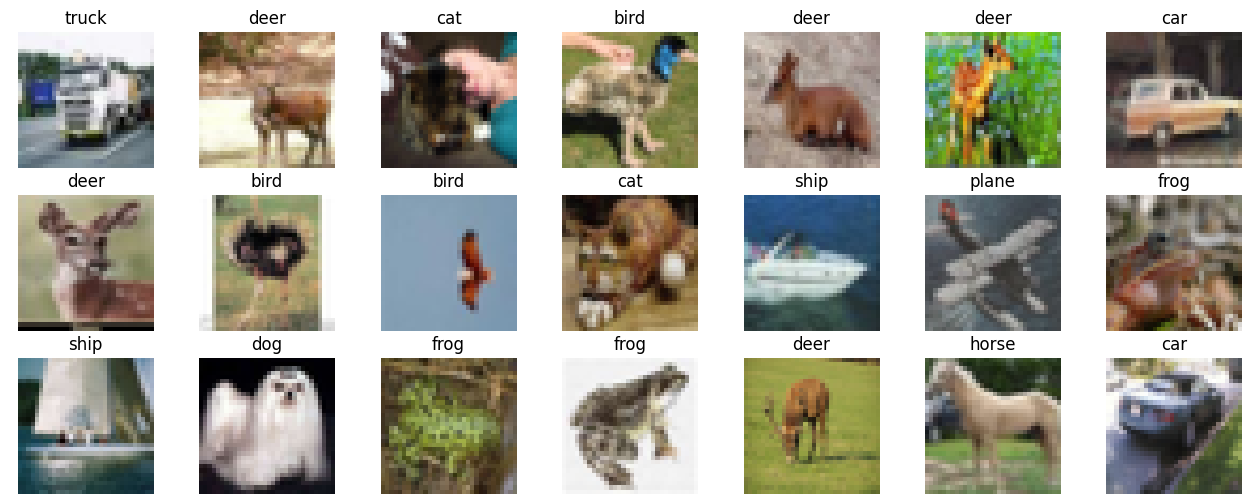

In [49]:
plt.figure(figsize=(16, 6))
# plt.title("CIFAR10 Dataset")
plt.axis('off')

for i in range(21):
    x, y = dataset_train_[1000 + i]
    x = torch.permute(x, [1, 2, 0]).numpy()
    plt.subplot(3, 7, i + 1)
    plt.title(f'{classes[y]}')
    plt.axis('off')
    plt.imshow(x)

plt.show()

### Архитектуры моделей

In [236]:
LATENT_DIM = 128

class DepthSeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, **kwargs):
        super(DepthSeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, padding=padding, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x1):
        x2 = self.depthwise(x1)
        x3 = self.pointwise(x2)
        return x3


class Encoder_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = "Encoder_1"

        self.fc1 = nn.Linear(32 * 32 * 3, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 128)

        self.bn1 = nn.BatchNorm1d(256)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)

        self.out_mean = nn.Linear(128, LATENT_DIM)
        self.out_log_var = nn.Linear(128, LATENT_DIM)

        self.dropout = nn.Dropout(p=0.0)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.dropout(F.relu(self.bn1(self.fc1(x))))
        x = self.dropout(F.relu(self.bn2(self.fc2(x))))
        x = self.dropout(F.relu(self.bn3(self.fc3(x))))
        out_mean = self.out_mean(x)
        out_log_var = self.out_log_var(x)
        return out_mean, out_log_var

class Decoder_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = "Decoder_1"

        self.fc1 = nn.Linear(LATENT_DIM, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 32 * 32 * 3)

        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(256)

        self.dropout = nn.Dropout(p=0.0)

    def forward(self, x):
        x = self.dropout(F.relu(self.bn1(self.fc1(x))))
        x = self.dropout(F.relu(self.bn2(self.fc2(x))))
        x = self.dropout(F.relu(self.bn3(self.fc3(x))))
        x = F.sigmoid(self.fc4(x))
        out_img = torch.reshape(x, (-1, 3, 32, 32))
        return out_img


class Encoder_2(nn.Module):
    class Block(nn.Module):
        def __init__(self, in_channels: int, out_channels: int, kernel_size=3, bn=True, drop=0.1, **kwargs):
            super().__init__()
            self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=1, **kwargs)
            self.bn = nn.BatchNorm2d(out_channels, momentum=0.01) if bn else None
            self.act = nn.LeakyReLU(negative_slope=0.1)
            self.dropout = nn.Dropout2d(p=drop) if drop else None

        def forward(self, x_in):
            x = self.conv(x_in)
            x = self.bn(x) if self.bn else x
            x = self.act(x)
            x = self.dropout(x) if self.dropout else x
            return x
    
    def __init__(self):
        super().__init__()
        self.name = "Encoder_2"
        
        self.first_layer = nn.Sequential(nn.Conv2d(3, 48, kernel_size=5, padding=2), nn.ReLU())
        self.block1 = Encoder_2.Block(in_channels=48, out_channels=64, kernel_size=4, drop=0.1, stride=2)     # 32x32
        self.block2 = Encoder_2.Block(in_channels=64, out_channels=128, kernel_size=3, drop=0.1, stride=2)     # 16x16
        self.block3 = Encoder_2.Block(in_channels=128, out_channels=256, kernel_size=3, drop=0.13, stride=2)   # 8x8
        self.block4 = Encoder_2.Block(in_channels=256, out_channels=512, kernel_size=3, drop=0.13, stride=2)  # 4x4
        # self.avg = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Sequential(nn.Flatten(), nn.Linear(2*2*512, 128), nn.BatchNorm1d(128, momentum=0.01), nn.LeakyReLU(negative_slope=0.1),)
        self.out_mean = nn.Linear(128, LATENT_DIM)
        self.out_log_var = nn.Linear(128, LATENT_DIM)

    def forward(self, x):
        x = self.first_layer(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        # x = self.avg(x)
        x = self.fc(x)
        out_mean = self.out_mean(x)
        out_log_var = self.out_log_var(x)
        return out_mean, out_log_var

class Decoder_2(nn.Module):
    class Block(nn.Module):
        def __init__(self, in_channels: int, out_channels: int, kernel_size=3, bn=True, drop=0.1, **kwargs):
            super().__init__()
            self.conv = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=1, **kwargs)
            self.bn = nn.BatchNorm2d(out_channels, momentum=0.01) if bn else None
            self.act = nn.LeakyReLU(negative_slope=0.1)
            self.dropout = nn.Dropout2d(p=drop) if drop else None

        def forward(self, x_in):
            x = self.conv(x_in)
            x = self.bn(x) if self.bn else x
            x = self.act(x)
            x = self.dropout(x) if self.dropout else x
            return x
    
    def __init__(self):
        super().__init__()
        self.name = "Decoder_2"
        
        self.input_layer = nn.Sequential(nn.Linear(LATENT_DIM, 4*4*128), nn.BatchNorm1d(4*4*128, momentum=0.01), nn.LeakyReLU(0.1), nn.Dropout(0.15))
        self.block1 = Decoder_2.Block(in_channels=128, out_channels=512, kernel_size=4, drop=0.1, stride=2)
        self.block2 = Decoder_2.Block(in_channels=512, out_channels=256, kernel_size=4, drop=0.12, stride=2)
        self.block3 = Decoder_2.Block(in_channels=256, out_channels=128, kernel_size=4, drop=0.1, stride=2)
        self.last_layer = nn.Sequential(nn.Conv2d(128, 3, kernel_size=3, padding=1), nn.Sigmoid())

    def forward(self, x):
        x = torch.reshape(self.input_layer(x), (-1, 128, 4, 4))
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        out_img = self.last_layer(x)
        return out_img

In [240]:
class VAE(nn.Module):
    base_name = "VAE_Model"
    def __init__(self, encoder: nn.Module, decoder: nn.Module, name=base_name):
        super().__init__()
        self.name = name
        self.encoder = encoder
        self.decoder = decoder

    @staticmethod
    def get_sample_z(mean, log_var):
        rand = torch.randn_like(log_var, device=device)
        z = mean + rand * torch.exp(log_var / 2.)
        return z

    def forward(self, x):
        out_mean, out_log_var = self.encoder(x)
        z = self.get_sample_z(out_mean, out_log_var)
        out_img = self.decoder(z)
        return out_img, out_mean, out_log_var
    
    
# class VAE_mod(nn.Module):
#     class Reshape(nn.Module):
#         def __init__(self, *args):
#             super().__init__()
#             self.shape = args  
#         def forward(self, x):
#             return x.view(self.shape)
#         
#     class Trim(nn.Module):
#         def __init__(self):
#             super().__init__()
#         def forward(self, x):
#             return x[:, :, :32, :32]
#     
#     def __init__(self):
#         super().__init__()
#         
#         self.conv1 = nn.Conv2d(3, 32, 3, stride = 2, padding = 1)
#         self.conv2 = nn.Conv2d(32, 64, 3, stride = 2, padding = 1)
#         self.conv3 = nn.Conv2d(64, 128, 3, stride = 2, padding = 1)
#         self.flatten = nn.Flatten()
#         
#         self.linear_mean = nn.Linear(2048, 100)
#         self.linear_logvar = nn.Linear(2048, 100)
# 
#         self.linear = nn.Linear(100, 2048)
#         self.reshape = VAE_mod.Reshape(-1, 128, 4, 4)
#         self.deconv1 = nn.ConvTranspose2d(128, 64, 3, stride = 2, padding=0)
#         self.deconv2 = nn.ConvTranspose2d(64, 32, 3, stride = 2, padding=1)
#         self.deconv3 = nn.ConvTranspose2d(32, 3, 3, stride = 2, padding=1)
#         self.trim = VAE_mod.Trim()
#     
#     def reparameterized(self, mean, var):
#         eps = torch.randn(mean.size(0), mean.size(1)).to(device)
#         z = mean + eps * torch.exp(var / 2.)
#         return z
# 
#     def encode(self, x): # Using silu instead of relu here
#         x = F.silu(self.conv1(x))
#         x = F.silu(self.conv2(x))
#         x = self.conv3(x)
#         x = self.flatten(x)
#         mean = self.linear_mean(x)
#         var = self.linear_logvar(x)
#         z = self.reparameterized(mean, var)
#         return mean, var, z
# 
#     def decode(self, z):
#         z = self.linear(z)
#         z = self.reshape(z)
#         z = F.silu(self.deconv1(z))
#         z = F.silu(self.deconv2(z))
#         z = F.silu(self.deconv3(z))
#         z = self.trim(z)
#         z = F.sigmoid(z)
#         return z
#     
#     def forward(self, x):
#         mean, var, z = self.encode(x)
#         z = self.decode(z)
#         return z, mean, var

In [239]:
def train(model_training: nn.Module, optim: torch.optim.Optimizer, loss_fn, epochs=1000, callbacks=None):
    train_losses = {'loss': [], 'loss_mse': [], 'loss_kl': []}
    val_losses = {'loss': [], 'loss_mse': [], 'loss_kl': []}

    # Model Training
    model_training.train()
    for epoch in range(1, epochs+1):
        running_loss = running_loss_mse = running_loss_kl = 0
        for i, (images, _) in enumerate(train_loader):
            images = images.to(device)
            # Prevent accumulation of gradients
            optim.zero_grad()
            images_out, z_mean, z_log_var = model_training(images)
            loss_mse = loss_fn['mse'](images, images_out) * loss_mse_factor
            loss_kl = loss_fn['kl'](z_mean, z_log_var) * loss_kl_factor
            loss = loss_mse + loss_kl
            # Backprop
            loss.backward()
            optim.step()

            running_loss += loss.item()
            running_loss_mse += loss_mse.item()
            running_loss_kl += loss_kl.item()

            progress_bar(i, len(train_loader), prefix=f"Epoch {epoch} train: ",
                         suffix=f"loss: {loss.item() :.3f}  mse: {loss_mse.item() :.3f}  kl: {loss_kl.item() :.3f}")

        # Model Validation
        with torch.no_grad():
            model_training.train(False)
            val_loss = val_loss_mse = val_loss_kl = 0

            for i, (val_images, _) in enumerate(val_loader):
                val_images = val_images.to(device)
                # Forward propagation
                images_out, z_mean, z_log_var = model_training(val_images)

                loss_mse = loss_fn['mse'](val_images, images_out).item() * loss_mse_factor
                loss_kl = loss_fn['kl'](z_mean, z_log_var).item() * loss_kl_factor
                loss = loss_fn['loss'](val_images, images_out, z_mean, z_log_var).item()

                val_loss_mse += loss_mse
                val_loss_kl += loss_kl
                val_loss += loss

                progress_bar(i, len(val_loader), prefix=f"Epoch {epoch} val: ",
                             suffix=f"loss: {loss :.3f}  mse: {loss_mse :.3f}  kl: {loss_kl :.3f}")

        model_training.train()

        train_losses['loss'].append(running_loss / len(train_loader))
        train_losses['loss_kl'].append(running_loss_kl / len(train_loader))
        train_losses['loss_mse'].append(running_loss_mse / len(train_loader))

        val_losses['loss'].append((val_loss / len(val_loader)))
        val_losses['loss_kl'].append((val_loss_kl / len(val_loader)))
        val_losses['loss_mse'].append((val_loss_mse / len(val_loader)))

        progress_bar(len(train_loader), len(train_loader), prefix=f"Epoch {epoch}: ", length=10, percent=False,
                     suffix=f"Train(loss, mse, kl): {train_losses['loss'][-1] :.3f} {train_losses['loss_mse'][-1] :.3f}"
                            f" {train_losses['loss_kl'][-1] :.3f} \tVal(loss, mse, kl): {val_losses['loss'][-1] :.3f} "
                            f"{val_losses['loss_mse'][-1] :.3f} {val_losses['loss_kl'][-1] :.3f}" +
                            (f" \tLr (e-3): {callbacks['lr_scheduler'].optimizer.param_groups[0]['lr'] * 1e3:.2f}"
                             if callbacks and callbacks.get("lr_scheduler") else ""))

        if callbacks:
            if "early_stopping" in callbacks.keys():
                callbacks["early_stopping"].step(val_losses['loss'][-1])
                if callbacks["early_stopping"]:
                    print("INFO: Early stopping!")
                    break
            if "lr_scheduler" in callbacks.keys():
                callbacks["lr_scheduler"].step(val_losses['loss'][-1])

    model_training.train(False)
    return {"train_losses": train_losses,
            "val_losses": val_losses, }

### Обучение и сравнение моделей

In [241]:
encoder = Encoder_2().to(device)
decoder = Decoder_2().to(device)

model = VAE(encoder, decoder, name="VAE_CNN_1").to(device)
# model = VAE_mod().to(device)

# Summary
# print(str(info_summary(encoder, input_size=(128, 3, 32, 32))))
# print(str(info_summary(decoder, input_size=(128, 64))))
print(str(info_summary(model, input_size=(128, 3, 32, 32))))

# Define our loss function
loss_mse = nn.MSELoss()
loss_kl = lambda mean, log_var: -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
loss_mse_factor = 1.
loss_kl_factor = 1.

def loss_function(x_, x_pred, mean, log_var):
    mse = loss_mse(x_, x_pred)
    kl = loss_kl(mean, log_var)
    loss = mse * loss_mse_factor + kl * loss_kl_factor
    return loss

loss_fn_dict = {'mse': loss_mse, 'kl': loss_kl, 'loss': loss_function}

# Define the optimier
optimizer = torch.optim.Adam(model.parameters(), lr=1.5e-3)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=2e-3)
# optimizer = torch.optim.SGD(model.parameters(), lr=2e-3, momentum=0.1)

# Callbacks & Schedulers
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.65, min_lr=5e-5)
early_stopping = EarlyStopping(tolerance=8, min_delta=0.)
callbacks_model = {"lr_scheduler": lr_scheduler,
                   "early_stopping": early_stopping}

Layer (type:depth-idx)                   Output Shape              Param #
VAE_mod                                  [128, 3, 32, 32]          --
├─Conv2d: 1-1                            [128, 32, 16, 16]         896
├─Conv2d: 1-2                            [128, 64, 8, 8]           18,496
├─Conv2d: 1-3                            [128, 128, 4, 4]          73,856
├─Flatten: 1-4                           [128, 2048]               --
├─Linear: 1-5                            [128, 100]                204,900
├─Linear: 1-6                            [128, 100]                204,900
├─Linear: 1-7                            [128, 2048]               206,848
├─Reshape: 1-8                           [128, 128, 4, 4]          --
├─ConvTranspose2d: 1-9                   [128, 64, 9, 9]           73,792
├─ConvTranspose2d: 1-10                  [128, 32, 17, 17]         18,464
├─ConvTranspose2d: 1-11                  [128, 3, 33, 33]          867
├─Trim: 1-12                             [128, 3, 32

In [72]:
save_model(model)

Model saved!


In [ ]:
model = load_model(VAE)

Epoch 0: [390/390] |██████████| Train(loss, mse, kl): 19.955 0.192 19.763 	Val(loss, mse, kl): 0.466 0.187 0.279 	Lr (e-3): 2.00          
Epoch 1: [390/390] |██████████| Train(loss, mse, kl): 0.401 0.187 0.214 	Val(loss, mse, kl): 0.299 0.187 0.112 	Lr (e-3): 2.00          
Epoch 2: [390/390] |██████████| Train(loss, mse, kl): 0.303 0.186 0.117 	Val(loss, mse, kl): 0.283 0.187 0.096 	Lr (e-3): 2.00          
Epoch 3: [390/390] |██████████| Train(loss, mse, kl): 0.264 0.186 0.078 	Val(loss, mse, kl): 0.265 0.186 0.079 	Lr (e-3): 2.00          
Epoch 4: [390/390] |██████████| Train(loss, mse, kl): 0.250 0.186 0.064 	Val(loss, mse, kl): 0.298 0.186 0.112 	Lr (e-3): 2.00          
Epoch 5: [390/390] |██████████| Train(loss, mse, kl): 0.243 0.186 0.057 	Val(loss, mse, kl): 0.238 0.205 0.033 	Lr (e-3): 2.00          
Epoch 6: [390/390] |██████████| Train(loss, mse, kl): 0.239 0.186 0.053 	Val(loss, mse, kl): 0.219 0.186 0.032 	Lr (e-3): 2.00          
Epoch 7: [390/390] |██████████| Train(l

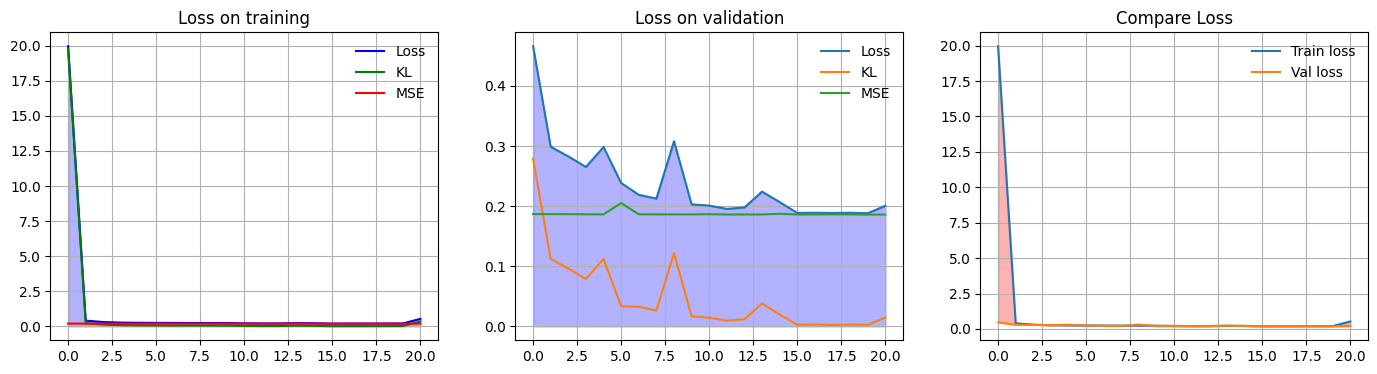

0.5462018 0.47310707 0.39169547


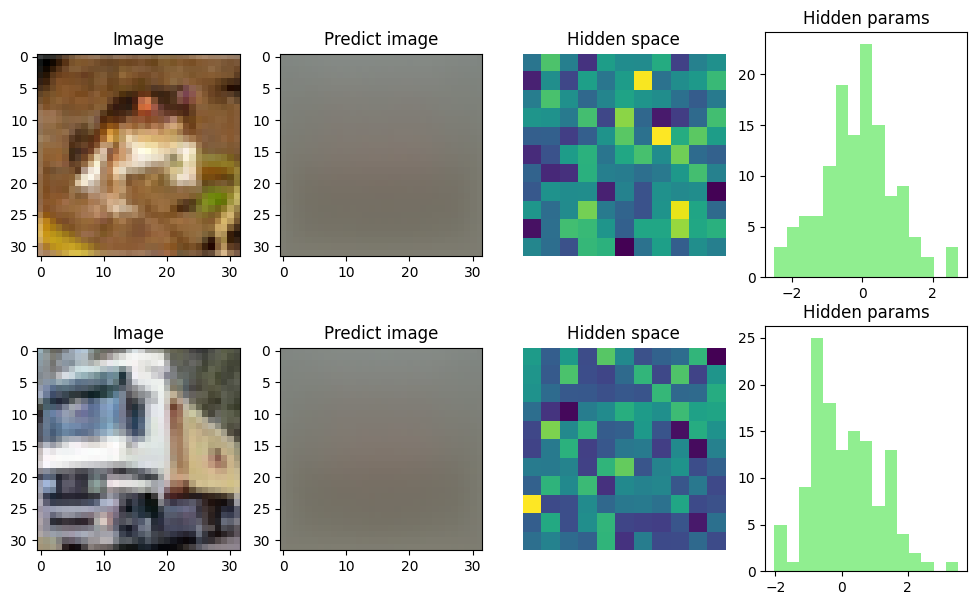

0.5550784 0.47374773 0.39151752


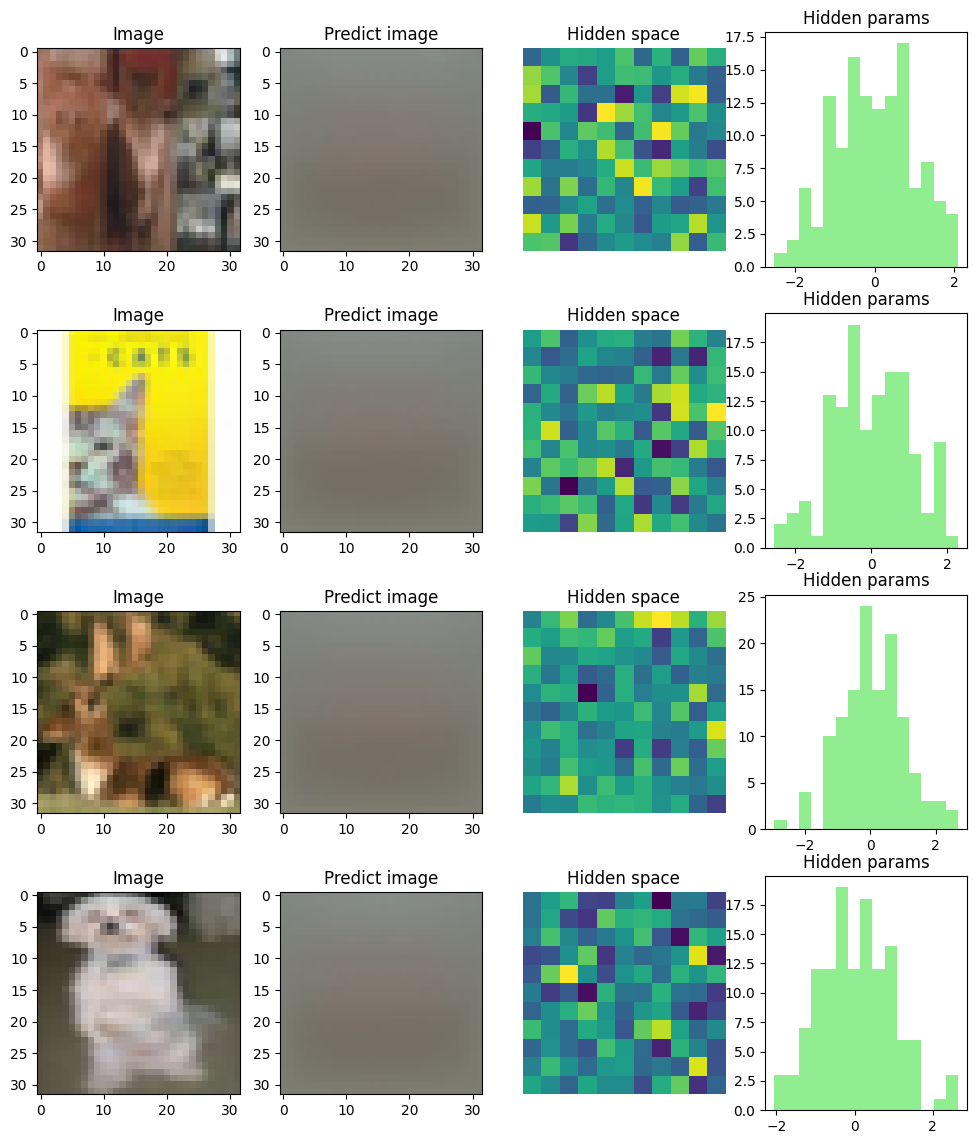

In [231]:
history = train(model, optimizer, loss_fn_dict, callbacks=callbacks_model)

show_history(history)
test_model(model, train_loader, imgs_count=2, save_fname='test_2')
test_model(model, val_loader, imgs_count=4)

### Итоги работы
В ходе работы я обработал и подготовил датасет CIFAR10, протестировали разные модели (полносвязные и сверточные) и сравнил их эффективность. Я посторил VAE, однако так и не получилось создать правдоподобную реконструкцию
[https://www.kaggle.com/code/brunomacedosanches/vq-vae-on-cifar10#Helper-functions](https://www.kaggle.com/code/brunomacedosanches/vq-vae-on-cifar10#Helper-functions)
[https://medium.com/@arjun.majumdar/variational-autoencoder-cifar-10-tf2-9ed1155771e1](https://medium.com/@arjun.majumdar/variational-autoencoder-cifar-10-tf2-9ed1155771e1)
[https://www.kaggle.com/code/leoliu1415/convolutional-vae-on-cifar10](https://www.kaggle.com/code/leoliu1415/convolutional-vae-on-cifar10)